# Support Team Operational Analysis

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Data Wrangling

## Імпорт даних

Із csv файлу з даними ми отримали наступний dataframe.

In [2]:
df = pd.read_csv('support.csv')
df.head()

,moderator,id_request,request_time,start_time,finish_time,team
0,165,159660,2020-09-24 7:01:16,2020-10-01 16:00:31,2020-10-01 16:02:02,retail
1,178,160116,2020-09-24 22:32:15,2020-10-01 13:21:42,2020-10-01 13:21:43,retail
2,187,160178,2020-09-25 2:58:13,2020-10-02 11:37:16,2020-10-02 11:41:56,wholesale
3,178,160306,2020-09-25 9:44:12,2020-10-02 7:23:09,2020-10-02 7:25:33,retail
4,178,163042,2020-09-30 15:56:08,2020-10-02 7:37:33,2020-10-02 7:47:57,retail


## Форматування дат

Три колонки містять нестандартний формат дат та мають бути перетворені на datetime дані.

In [3]:
df['request_time'] = pd.to_datetime(df['request_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['finish_time'] = pd.to_datetime(df['finish_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

Можемо перевірити типи даних через метод `info()`.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35617 entries, 0 to 35616
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   moderator     35617 non-null  int64         
 1   id_request    35617 non-null  int64         
 2   request_time  35617 non-null  datetime64[ns]
 3   start_time    35617 non-null  datetime64[ns]
 4   finish_time   35617 non-null  datetime64[ns]
 5   team          35617 non-null  object        
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 1.6+ MB


## Чистка даних

По-перше, перевіримо, чи є в датафреймі нульові значення.

In [5]:
df.isnull().any()

moderator       False
id_request      False
request_time    False
start_time      False
finish_time     False
team            False
dtype: bool

Нульових значень немає в жодній колонці. Це також значить, що усі дати були перетворені на `datetime`формат, адже помилкові значення мали петертворитися на `NaD`.

По-друге, перевіримо дані на дублікати. 
Спершу слід визначити, чи немає повних повних співпадінь по рядках.

In [6]:
df.duplicated().any()

np.False_

Також слід перевірити, чи немає реквестів з однаковим id, адже це єдина колонка, яка має містити лише унікальні значення.

In [7]:
df.duplicated(subset=['id_request']).any()

np.False_

По-третє, слід перевірити колонки на очевидно помилково введені значення.

Кожна колонка з датами має передувати у часі наступній колонці, адже неможливо, аби робота над запитом почалася до його надходження, чи завершилася до початку роботи над ним.

In [8]:
df.loc[df['request_time']>=df['start_time']]

,moderator,id_request,request_time,start_time,finish_time,team


In [9]:
df.loc[df['start_time']>=df['finish_time']]

,moderator,id_request,request_time,start_time,finish_time,team


Жодний запис не порушує логічної послідовності у часі.

Також можна перевірити, які унікальні значення існують в колонці `'team'`, адже наразі в підтримці існують лише дві команди: роздрібного і гуртового продажу.

In [10]:
df['team'].unique()

array(['retail', 'wholesale'], dtype=object)

Як і очікувалося, у колонці вказані лише два валідні значення.

## Пошук помилкових чи аномальних значень

Аби не зіпсувати загальної статистики, слід виключити усі значення, які здаються помилково введеними та неадекватними.

Наприклад, варто перевірити, чи існують в даних випадки занадто короткого опрацювання запитів. Якщо співробітник може узяти в роботу запит одразу після його появи, закінчення роботи у декілька секунд здається нереалістичним.

In [11]:
sec_5 = dt.timedelta(seconds=5)
sec_3 = dt.timedelta(seconds=3)
sec_2 = dt.timedelta(seconds=2)
sec_1 = dt.timedelta(seconds=1)

resolution_5_sec = df.loc[df['finish_time']-df['start_time']<=sec_5,['id_request']]
resolution_3_sec = df.loc[df['finish_time']-df['start_time']<=sec_3,['id_request']]
resolution_2_sec = df.loc[df['finish_time']-df['start_time']<=sec_2,['id_request']]
resolution_1_sec = df.loc[df['finish_time']-df['start_time']<=sec_1,['id_request']]

pd.DataFrame({
    'n_cases' : {'resolution_5_sec' : len(resolution_5_sec),
                 'resolution_3_sec' : len(resolution_3_sec),
                 'resolution_2_sec' : len(resolution_2_sec),
                 'resolution_1_sec' : len(resolution_1_sec)},
    'proportion' : {'resolution_5_sec' : len(resolution_5_sec) / len(df),
                    'resolution_3_sec' : len(resolution_3_sec) / len(df),
                    'resolution_2_sec' : len(resolution_2_sec) / len(df),
                    'resolution_1_sec' : len(resolution_1_sec) / len(df)}
})

,n_cases,proportion
resolution_5_sec,1070,0.030042
resolution_3_sec,807,0.022658
resolution_2_sec,687,0.019289
resolution_1_sec,496,0.013926


Виявилося, що доволі багато запитів було закінчено за декілька секунд після прийняття. Близько 3% усіх запитів було оброблено протягом 5 секунд, а 1,4% запитів було оброблено лише за одну секунду. Це доволі значний відсоток.
Можна розглянути це візуально.

Text(0.5, 0, 'Тривалість опрацювання (секунди)')

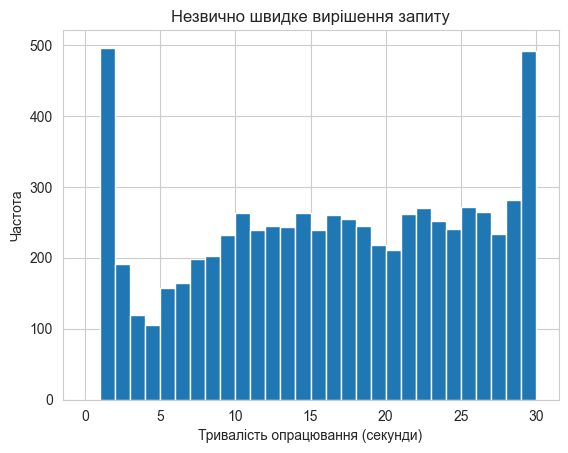

In [12]:
resolution_time = (df['finish_time']-df['start_time']).dt.total_seconds()
plt.hist(resolution_time, bins=30, range=[0,30])
plt.title('Незвично швидке вирішення запиту')
plt.ylabel('Частота')
plt.xlabel('Тривалість опрацювання (секунди)')

Як видно із гістограми, яка показує частоту виконання запитів протягом 1 хвилини, швидке виконання не є чимось незвичним у будь-якому проміжку між 1 та 60 секундами. Навпаки, виконання за 1 секунду зустрічається частіше, аніж виконання за інший короткий час до 10 секунд. 

Із цього можна зробити висновок, що хоча такий час здається нереалістичним, він може бути результатом автоматизації процесів, відмов, чи інших внутрішніх процесів. Варто дізнатися, чи не є виконання в одну секунду результатом повторюваного помилкового відправлення відповідей до їхнього написання чи помилки в записі даних. У будь-якому випадку, автоматизовані відповіді слід позначати в базі даних, аби вони не впливали на загальну статистику. Враховуючи велику кількість випадків із швидким виконанням, ми **не виключатимемо** такі записи як аномальні та будемо враховувати їх при підрахунку.

Також слід перевірити, чи присутні в даних випадки з неадекватно довгим часом опрацювання запитів. Виконання завдання протягом більшого часу, аніж середній робочий день, було б дивним.

In [13]:
hours_8 = dt.timedelta(hours=8)
df.loc[df['finish_time']-df['start_time']>hours_8,['id_request']]

,id_request


Такі випадки відсутні.

Також на аномальність слід перевірити те, скільки запитів було опрацьовано різними модераторами.

In [14]:
df['moderator'].value_counts()

moderator
188    3746
112    1717
170    1686
181    1625
123    1452
180    1349
186    1342
102    1321
103    1313
117    1251
187    1193
125    1146
172     946
146     909
135     857
153     838
109     827
176     803
121     799
122     767
149     751
156     748
136     747
148     741
141     713
165     698
164     640
178     630
173     613
116     580
111     569
167     536
152     477
175     420
128     237
161     181
143     141
163     130
144      61
114      60
185      25
150      16
134       8
126       2
133       2
110       1
138       1
129       1
171       1
Name: count, dtype: int64

Деякі співробітники виконали занадто мало робіт, аби з них можна було впевнено вирахувати середнє значення, не приділяючи забагато ваги лише декільком значенням. Для адекватної оцінки, можна зробити cut-0ff у мінімум 15 оброблених запитів. Відтак, сім модераторів, які виконали 1, 2 чи 8 завдань, будуть виключені зі статистики, яка стосується саме оцінки роботи модераторів. Враховуючи, що запити все ж були оброблені, вони не будуть виключені з оцінки роботи підтримки загалом, кожної з команд та статистики з часового розрізу. 

## Додаткові 

Для зручності аналізу, можна створити із наявних атрибутів нові колонки, які потім будуть використовуватися для обчислень чи розбивання на когорти. 

### Тривалість

Для розрахунку тривалості, можна одразу створити колонки для:
1. **Holding time**, тобто час між отриманням запиту та початком роботи над ним.
2. **Resolution time**, тобто час між початком опрацювання до закінчення опрацювання запиту.

Усі тривалості можна зберегти у форматі `timedelta`, на випадок необхідності додавання чи віднімання від дат, та у числовому форматі (хвилинах) для звичайних обчислень.

In [15]:
df['holding_time'] = df['start_time']-df['request_time']
df['holding_time_min'] = df['holding_time'].dt.total_seconds()/60
df['resolution_time'] = df['finish_time']-df['start_time']
df['resolution_time_min'] = df['resolution_time'].dt.total_seconds()/60

### Циклічні проміжки

Для когортного аналізу у часі, варто створити колонки для:
1. **Дня тижня**
2. **Дати**
3. **Години дня**

Варто створити такі колонки як для часу реквесту, так і для часу початку роботи, адже між ними буває велика різниця.

In [16]:
df['request_weekday'] = df['request_time'].dt.dayofweek
df['start_weekday'] = df['start_time'].dt.dayofweek

df['request_date'] = df['request_time'].dt.date
df['start_date'] = df['start_time'].dt.date

df['request_hour'] = df['request_time'].dt.hour
df['start_hour'] = df['start_time'].dt.hour

### Оновлений DataFrame

In [17]:
df.head()

,moderator,id_request,request_time,start_time,finish_time,team,holding_time,holding_time_min,resolution_time,resolution_time_min,request_weekday,start_weekday,request_date,start_date,request_hour,start_hour
0,165,159660,2020-09-24 07:01:16,2020-10-01 16:00:31,2020-10-01 16:02:02,retail,7 days 08:59:15,10619.250000,0 days 00:01:31,1.516667,3,3,2020-09-24,2020-10-01,7,16
1,178,160116,2020-09-24 22:32:15,2020-10-01 13:21:42,2020-10-01 13:21:43,retail,6 days 14:49:27,9529.450000,0 days 00:00:01,0.016667,3,3,2020-09-24,2020-10-01,22,13
2,187,160178,2020-09-25 02:58:13,2020-10-02 11:37:16,2020-10-02 11:41:56,wholesale,7 days 08:39:03,10599.050000,0 days 00:04:40,4.666667,4,4,2020-09-25,2020-10-02,2,11
3,178,160306,2020-09-25 09:44:12,2020-10-02 07:23:09,2020-10-02 07:25:33,retail,6 days 21:38:57,9938.950000,0 days 00:02:24,2.400000,4,4,2020-09-25,2020-10-02,9,7
4,178,163042,2020-09-30 15:56:08,2020-10-02 07:37:33,2020-10-02 07:47:57,retail,1 days 15:41:25,2381.416667,0 days 00:10:24,10.400000,2,4,2020-09-30,2020-10-02,15,7


### DataFrames для команд

In [18]:
df_retail = df[df['team'] == 'retail']
df_wholesale = df[df['team'] == 'wholesale']

# Analysis

## Health Evaluation

Почнемо аналіз із загальної оцінки роботи служби підтримки, порівнюючи наявні показники із очікуваннями менеджменту.

### Визначення Targets

Відомо, що "**старанний агент** служби підтримки" може виконати завдання за **5 хвилин**.
Менеджмент очікує, що середній час від виникнення нового запиту користувача до відповіді має бути **15 хвилин**. Також погано, якщо користувачі сервісу чекають на відповідь **довше 45 хвилин**.

Отже, **holdong time** (від запиту до початку роботи) може бути:
1. <span style="color:green">Бажаний</span>: до 15 хвилин.
2. <span style="color:blue">Прийнятний</span>: від 15 до 45 хвилин.
3. <span style="color:red">Небажаний</span>: більше 45 хвилин.

Враховуючи, що при ефективній роботі працівник служби підтримки опрацьовує запит за щонайбільше 5 хвилин, границею прийнятної відповіді можна вважати 10 хвилин, яке удвічі перевищує рекомендацію. 

Відтак, **resolution time** (від початку опрацювання до завершення) може бути:
1. <span style="color:green">Бажаний</span>: до 5 хвилин.
2. <span style="color:blue">Прийнятний</span>: від 5 до 10 хвилин.
3. <span style="color:red">Небажаний</span>: більше 10 хвилин.

In [19]:
holding_desired = 15
holding_undesired = 45
resolution_desired = 5
resolution_undesired = 10

### Огляд показників

Для оцінки роботи підтримки, перш за все, можна підрахувати середню тривалість очікування та роботи над запитом.

In [20]:
# Середні показники обох команд
avg_holding_time = np.round(np.average(df['holding_time_min']),2)
median_holding_time = np.round(np.median(df['holding_time_min']),2)
avg_resolution_time = np.round(np.average(df['resolution_time_min']),2)
median_resolution_time = np.round(np.median(df['resolution_time_min']),2)
# Середні показники команди роздрібної торгівлі
avg_holding_time_retail = np.round(np.average(df_retail['holding_time_min']),2)
median_holding_time_retail = np.round(np.median(df_retail['holding_time_min']),2)
avg_resolution_time_retail = np.round(np.average(df_retail['resolution_time_min']),2)
median_resolution_time_retail = np.round(np.median(df_retail['resolution_time_min']),2)
# Середні показники команди оптової торгівлі
avg_holding_time_wholesale = np.round(np.average(df_wholesale['holding_time_min']),2)
median_holding_time_wholesale = np.round(np.median(df_wholesale['holding_time_min']),2)
avg_resolution_time_wholesale = np.round(np.average(df_wholesale['resolution_time_min']),2)
median_resolution_time_wholesale = np.round(np.median(df_wholesale['resolution_time_min']),2)

In [21]:
average_metrics = pd.DataFrame({
    'Цільові показники' : [holding_desired, holding_desired, resolution_desired, resolution_desired], 
    'Обидві команди' : [avg_holding_time, median_holding_time, avg_resolution_time, median_resolution_time],
    'Retail команда' : [avg_holding_time_retail, median_holding_time_retail, avg_resolution_time_retail, median_resolution_time_retail],
    'Wholesale команда' : [avg_holding_time_wholesale, median_holding_time_wholesale, avg_resolution_time_wholesale, median_resolution_time_wholesale]
    }, index=['Середній час очікування', 'Медіана очікування', 'Середній час опрацювання', 'Медіана часу опрацювання'])
        
average_metrics

,Цільові показники,Обидві команди,Retail команда,Wholesale команда
Середній час очікування,15,2468.73,607.79,3677.49
Медіана очікування,15,497.62,48.38,3749.77
Середній час опрацювання,5,2.24,1.98,2.42
Медіана часу опрацювання,5,1.40,1.32,1.45


Ми отримали цікаві результати.

З одного боку, середній час **від реквесту до початку** його опрацювання є неприйнятним, і **значно перевищує** нижню встановлену планку.

З іншого боку, середній час **опрацювання** запиту не лише є прийнятним, але й удвічі меншим за **бажаний рівень**.

### Огляд часу очікування (holding time)

Слід оцінити розподіл частот тривалості очікування. 

Створимо три гістограми, аби отримати уявлення про тривалість очікуваняння у різних масштабах.

Text(0.02, 0.5, 'Кількість випадків')

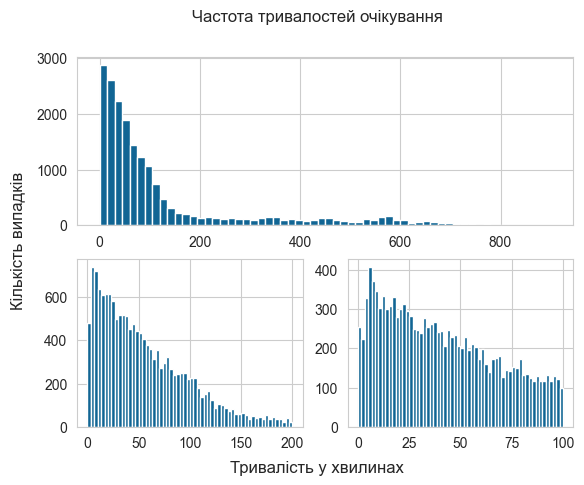

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, (1, 2))
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)
ax1.hist(df['holding_time_min'], bins=60, range=[0,900], color='#116594')
ax2.hist(df['holding_time_min'], bins=60, range=[0,200], color='#116594')
ax3.hist(df['holding_time_min'], bins=60, range=[0,100], color='#116594')
fig.suptitle('Частота тривалостей очікування')
fig.supxlabel('Тривалість у хвилинах')
fig.supylabel('Кількість випадків')

Як видно, більшість запитів очікують відповіді **протягом трьох годин**, тоді як **неприйнятно велика тривалість очікування** зустрічається з меншою частотою, проте констистентно. Також видно, що у розрізі 200 хвилин, розподіл має перекіс управо, а тому більша пропорція оброблюється за визначенний прийнятний час (45 хвилин).

Перевіримо, чи такий паттерн спільний для обох команд.

Text(0.02, 0.5, 'Кількість випадків')

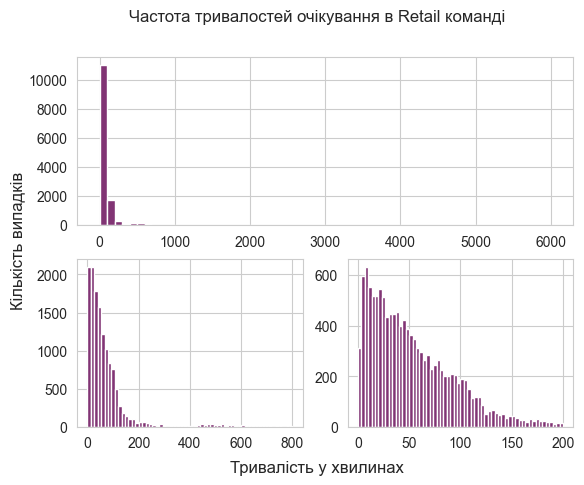

In [23]:
fig = plt.figure()
plt.suptitle('Retail')
ax1 = fig.add_subplot(2, 2, (1, 2))
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)
ax1.hist(df['holding_time_min'].loc[df['team']=='retail'], bins=60, range=[0,6000], color='#813474')
ax2.hist(df['holding_time_min'].loc[df['team']=='retail'], bins=60, range=[0,800], color='#813474')
ax3.hist(df['holding_time_min'].loc[df['team']=='retail'], bins=60, range=[0,200], color='#813474')
fig.suptitle('Частота тривалостей очікування в Retail команді')
fig.supxlabel('Тривалість у хвилинах')
fig.supylabel('Кількість випадків')

Text(0.02, 0.5, 'Кількість випадків')

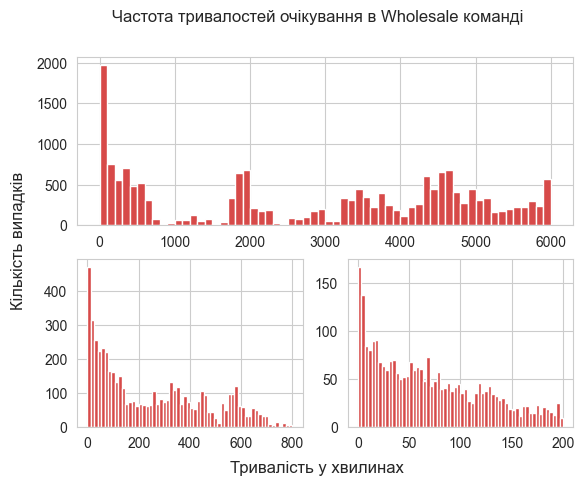

In [24]:
fig = plt.figure()
plt.suptitle('Wholesale')
ax1 = fig.add_subplot(2, 2, (1, 2))
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)
ax1.hist(df['holding_time_min'].loc[df['team']=='wholesale'], bins=60, range=[0,6000], color='#d74a49')
ax2.hist(df['holding_time_min'].loc[df['team']=='wholesale'], bins=60, range=[0,800], color='#d74a49')
ax3.hist(df['holding_time_min'].loc[df['team']=='wholesale'], bins=60, range=[0,200], color='#d74a49')
fig.suptitle('Частота тривалостей очікування в Wholesale команді')
fig.supxlabel('Тривалість у хвилинах')
fig.supylabel('Кількість випадків')

Як видно, **ситуація значно гірша** для **гуртового продажу**, у якому час очікування сягає великих значень. У загальному графіку, **адекватна тривалість** очікування великою мірою завдячує **роздрібній торгівлі**, тоді як найбільші **девіації** походять від **гуртової**.

### Видалення екстремальних значень

Ми відразаємо усі випадки очікування більше 1440 хвилин (24 години), адже вони говорять про внутрішні проблеми та мають бути вирішені окремо.

In [25]:
df_nrm = df.loc[df['holding_time_min'] <= 1440]
df_retail_nrm = df_nrm[df_nrm['team'] == 'retail']
df_wholesale_nrm = df_nrm[df_nrm['team'] == 'wholesale']

print("Видалено", len(df) - len(df_nrm), "записів з часом очікування від 1440 хвилин (24 години). Це", np.round(((len(df) - len(df_nrm))/len(df)*100), 2), "% від усіх запитів.")
print("Було видалено", len(df_wholesale) - len(df_wholesale_nrm), "записів з wholesale команди. Це", np.round(((len(df_wholesale) - len(df_wholesale_nrm))/len(df_wholesale)*100), 2), "% від її запитів.")

Видалено 16083 записів з часом очікування від 1440 хвилин (24 години). Це 45.16 % від усіх запитів.
Було видалено 15804 записів з wholesale команди. Це 73.19 % від її запитів.


### Огляд часу очікування після видалення екстремальних значень

In [26]:
# Середні показники обох команд
avg_holding_time = np.round(np.average(df_nrm['holding_time_min']),2)
median_holding_time = np.round(np.median(df_nrm['holding_time_min']),2)
avg_resolution_time = np.round(np.average(df_nrm['resolution_time_min']),2)
median_resolution_time = np.round(np.median(df_nrm['resolution_time_min']),2)
# Середні показники команди роздрібної торгівлі
avg_holding_time_retail = np.round(np.average(df_retail_nrm['holding_time_min']),2)
median_holding_time_retail = np.round(np.median(df_retail_nrm['holding_time_min']),2)
avg_resolution_time_retail = np.round(np.average(df_retail_nrm['resolution_time_min']),2)
median_resolution_time_retail = np.round(np.median(df_retail_nrm['resolution_time_min']),2)
# Середні показники команди оптової торгівлі
avg_holding_time_wholesale = np.round(np.average(df_wholesale_nrm['holding_time_min']),2)
median_holding_time_wholesale = np.round(np.median(df_wholesale_nrm['holding_time_min']),2)
avg_resolution_time_wholesale = np.round(np.average(df_wholesale_nrm['resolution_time_min']),2)
median_resolution_time_wholesale = np.round(np.median(df_wholesale_nrm['resolution_time_min']),2)
# Таблиця середніх значень
average_metrics_nrm = pd.DataFrame({
    'Цільові показники' : [holding_desired, holding_desired, resolution_desired, resolution_desired], 
    'Обидві команди' : [avg_holding_time, median_holding_time, avg_resolution_time, median_resolution_time],
    'Retail команда' : [avg_holding_time_retail, median_holding_time_retail, avg_resolution_time_retail, median_resolution_time_retail],
    'Wholesale команда' : [avg_holding_time_wholesale, median_holding_time_wholesale, avg_resolution_time_wholesale, median_resolution_time_wholesale]
    }, index=['Середній час очікування', 'Медіана очікування', 'Середній час опрацювання', 'Медіана часу опрацювання'])
        

In [27]:
average_metrics_nrm

,Цільові показники,Обидві команди,Retail команда,Wholesale команда
Середній час очікування,15,151.15,81.70,316.10
Медіана очікування,15,61.42,47.24,234.46
Середній час опрацювання,5,2.35,1.99,3.21
Медіана часу опрацювання,5,1.48,1.32,1.95


Слід розібратися у **причинах довгої тривалості** очікування. 
Можливі причини:
1. Неадекватна кількість співробітників на зміні в різний час.
2. Неадекватний розподіл співробітників по командам.
3. Довгий час обробки певних питань через їхню складність чи інші перепони.

Останню гіпотезу перевіримо зараз.

### Огляд часу опрацювання (resolution time)

Хоча **середній час** виявився **2.24 хвилини**, що краще навіть за бажаний результат у 5 хвилин, на цей результат могли значно вплинути виявлені вирішення за 1-5 секунд. Тому хороший середній показник може приховувати довгі часи обробки деяких питань, які збільшують час загального виконання.

Слід також дослідити розподіл через гістограму.

Text(0.02, 0.5, 'Кількість випадків')

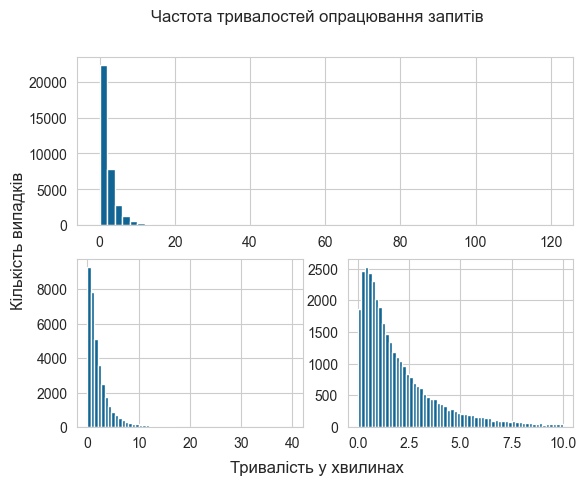

In [28]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, (1, 2))
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)
ax1.hist(df['resolution_time_min'], bins=60, range=[0,120], color='#116594')
ax2.hist(df['resolution_time_min'], bins=60, range=[0,40], color='#116594')
ax3.hist(df['resolution_time_min'], bins=60, range=[0,10], color='#116594')
fig.suptitle('Частота тривалостей опрацювання запитів')
fig.supxlabel('Тривалість у хвилинах')
fig.supylabel('Кількість випадків')

Як видно, переважна кількість реквестів оброблюється менш ніж за 5 хвилин, і майже всі реквести оброблюються не більше 10 хвилин.

Для кращого вивчиення варто зробити розбивку по командам.

Text(0.02, 0.5, 'Кількість випадків')

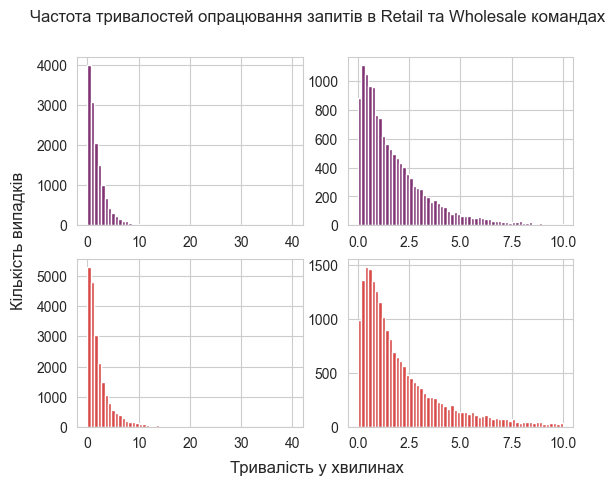

In [29]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
ax1.hist(df['resolution_time_min'].loc[df['team']=='retail'], bins=60, range=[0,40], color='#813474')
ax2.hist(df['resolution_time_min'].loc[df['team']=='retail'], bins=60, range=[0,10], color='#813474')
ax3.hist(df['resolution_time_min'].loc[df['team']=='wholesale'], bins=60, range=[0,40], color='#d74a49')
ax4.hist(df['resolution_time_min'].loc[df['team']=='wholesale'], bins=60, range=[0,10], color='#d74a49')
fig.suptitle('Частота тривалостей опрацювання запитів в Retail та Wholesale командах')
fig.supxlabel('Тривалість у хвилинах')
fig.supylabel('Кількість випадків')

Обидві команди успішно оброблюють запити переважно у бажаний час. В обох командах не спостерігається значних девіацій, які б негативно впливали на загальний час відповіді на запит.

Отже, причиною довгого часу в роботі не є висока тривалість опрацювання співробітниками.

## Показники роботи модераторів

Для оцінки роботи модераторів, слід підсумувати, скільки часу, в середньому, вони витрачають на опрацювання взятих у роботу кейсів.
Через те, що розподіл асиметричний (skewed), основним орієнтиром можна взяти **медіану часу опрацювань**. Також можна дослідити, з якої тривалості починаються найдовші 25% опрацювань для модератора, тобто верхній квартиль.

In [30]:
def q3(x):
    return x.quantile(0.75)
ranks = ['до 5 хв', 'від 5 хв до 10 хв', 'більше 10 хв']

moderators = df['resolution_time_min'].groupby(df['moderator']).agg([('Середнє часу опрацювань','mean'), ('Медіана часу опрацювань','median'),('Верхній квартиль часу опрацювань',q3),('Найдовший час опрацювання', 'max')])
moderators.index.names = ['ID модератора']
moderators = moderators.drop([171, 129, 138, 110, 133, 126, 134])
moderators['Оцінка медіани часу опрацювань'] = moderators['Медіана часу опрацювань'].apply(lambda x: ranks[0] if x <= resolution_desired else ranks[1] if x <= resolution_undesired else ranks[2])
moderators['Оцінка верхнього квартилю часу опрацювань'] = moderators['Верхній квартиль часу опрацювань'].apply(lambda x: ranks[0] if x <= resolution_desired else ranks[1] if x <= resolution_undesired else ranks[2])

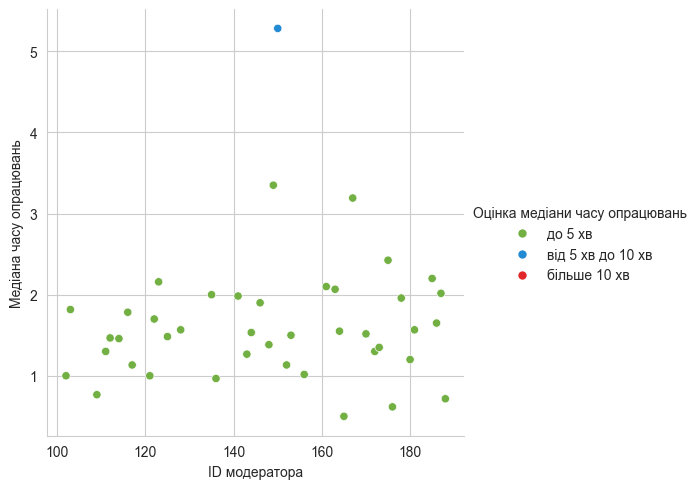

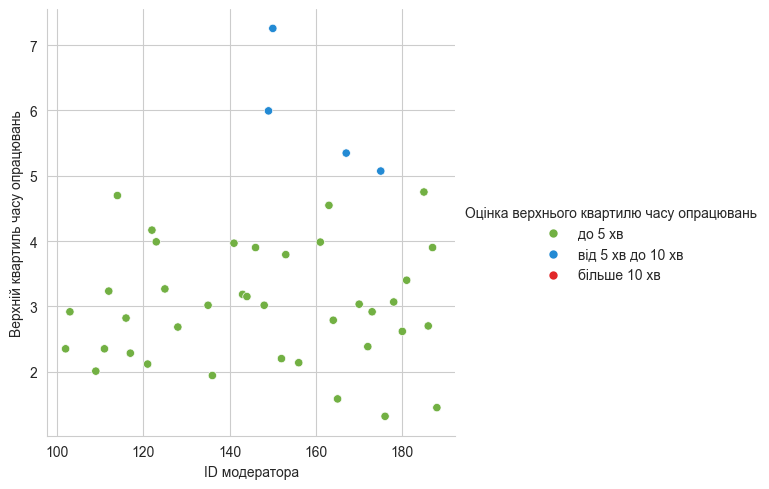

In [31]:
sns.relplot(kind='scatter', data=moderators, x='ID модератора', y='Медіана часу опрацювань', hue='Оцінка медіани часу опрацювань', palette=['#72b043','#238ad4','#e12729'], hue_order=ranks)
sns.relplot(kind='scatter', data=moderators, x='ID модератора', y='Верхній квартиль часу опрацювань', hue='Оцінка верхнього квартилю часу опрацювань', palette=['#72b043','#238ad4','#e12729'], hue_order=ranks)

Отже, в середньому **всі модератори** опрацьовують запити **до 5 хвилин**, окрім одного співробітника. Навіть у 25% своїй найповільніших опрацювань, усі співробітники опрацьовували запити до 10 хвилин.

Як видно із графіки, чотири співробітники у середньому не досягають бажаного рівня у 5 хвилин на опрацювання у 25% випадків. Варто визначити співробітників, чиї результати були помітно нижчими за середні.

In [32]:
moderators[moderators['Оцінка верхнього квартилю часу опрацювань'] != "до 5 хв"]

,Середнє часу опрацювань,Медіана часу опрацювань,Верхній квартиль часу опрацювань,Найдовший час опрацювання,Оцінка медіани часу опрацювань,Оцінка верхнього квартилю часу опрацювань
ID модератора,,,,,,
149,4.351110,3.350000,5.991667,18.950000,до 5 хв,від 5 хв до 10 хв
150,5.109375,5.283333,7.254167,12.416667,від 5 хв до 10 хв,від 5 хв до 10 хв
167,4.319994,3.191667,5.345833,19.133333,до 5 хв,від 5 хв до 10 хв
175,3.755159,2.425000,5.070833,19.983333,до 5 хв,від 5 хв до 10 хв


Отже, ми маємо лише одного outlier, **модератора із ID 150**, чиї результати були значно гірші за середні. 

Відтак, майже усі працівники підтримки, які виконали понад 15 замовлень, мають високу ефективність праці, що відповідають встановленим цілям.

## Розклад та розподіл навантаження

### Розподіл між командами

Слід оцінити, чи рівномірно розподілене навантаження та ресурси між командами

In [33]:
moderator_counts = df.groupby('team')['moderator'].nunique().reset_index(name='total_moderators')
request_counts = df.groupby('team')['id_request'].count().reset_index(name='total_requests')
team_summary = pd.merge(moderator_counts, request_counts, on='team')
team_summary['requests_per_moderator'] = team_summary['total_requests'] / team_summary['total_moderators']
team_summary

,team,total_moderators,total_requests,requests_per_moderator
0,retail,24,14025,584.375
1,wholesale,25,21592,863.680


In [34]:
print('Wholesale команда загалом отримала', np.round((21592-14025)/14025*100,1), '% більше запитів, аніж retail команда, маючи при цьому майже таку ж кількість співробітників.')

Wholesale команда загалом отримала 54.0 % більше запитів, аніж retail команда, маючи при цьому майже таку ж кількість співробітників.


### Огляд по годинам та дням тижня

#### Загальний розгляд обох команд

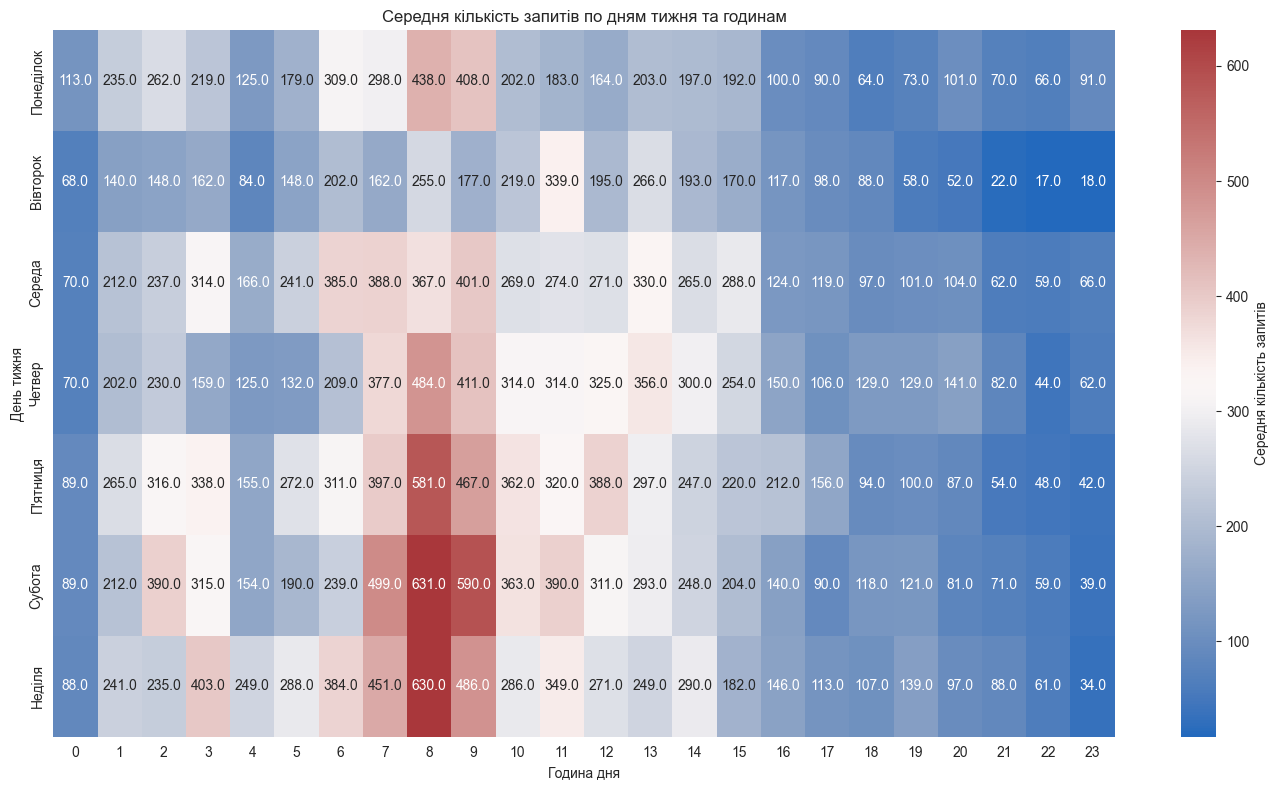

In [35]:
weekday_hourly_requests = df.groupby(['request_weekday', 'request_hour']).size().reset_index(name='request_count')
weekday_hourly_requests_avg = weekday_hourly_requests.groupby(
    ['request_weekday', 'request_hour']).agg(
        avg_requests=('request_count', 'median'), 
        variance_requests=('request_count', 'var')
).reset_index()

requests_avg_pivot = weekday_hourly_requests_avg.pivot(index='request_weekday', columns='request_hour', values='avg_requests')

plt.figure(figsize=(14, 8))
sns.heatmap(requests_avg_pivot, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Середня кількість запитів'})
plt.title('Середня кількість запитів по дням тижня та годинам')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('heatmap_requests_total.png')
plt.show()

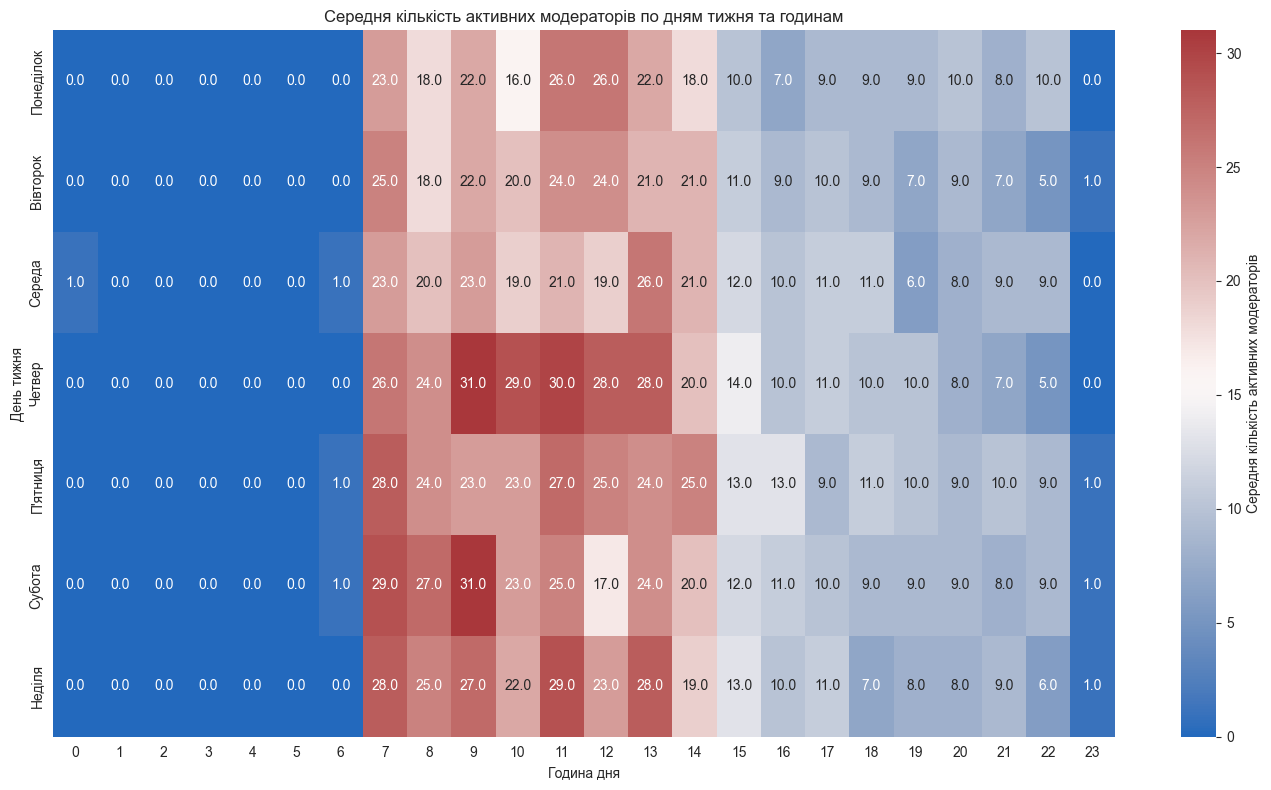

In [36]:
weekday_hourly_moderators = df.groupby(['start_weekday', 'start_hour'])['moderator'].nunique().reset_index(name='moderator_count')
weekday_hourly_moderators_avg = weekday_hourly_moderators.groupby(
    ['start_weekday', 'start_hour']).agg(
        avg_moderators=('moderator_count', 'median'),
        variance_moderators=('moderator_count', 'var')
).reset_index()

moderators_pivot = weekday_hourly_moderators_avg.pivot(index='start_weekday', columns='start_hour', values='avg_moderators').fillna(0)
moderators_pivot = moderators_pivot.reindex(columns=np.arange(24), fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(moderators_pivot, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Середня кількість активних модераторів'})
plt.title('Середня кількість активних модераторів по дням тижня та годинам')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('heatmap_moderators_total.png')
plt.show()

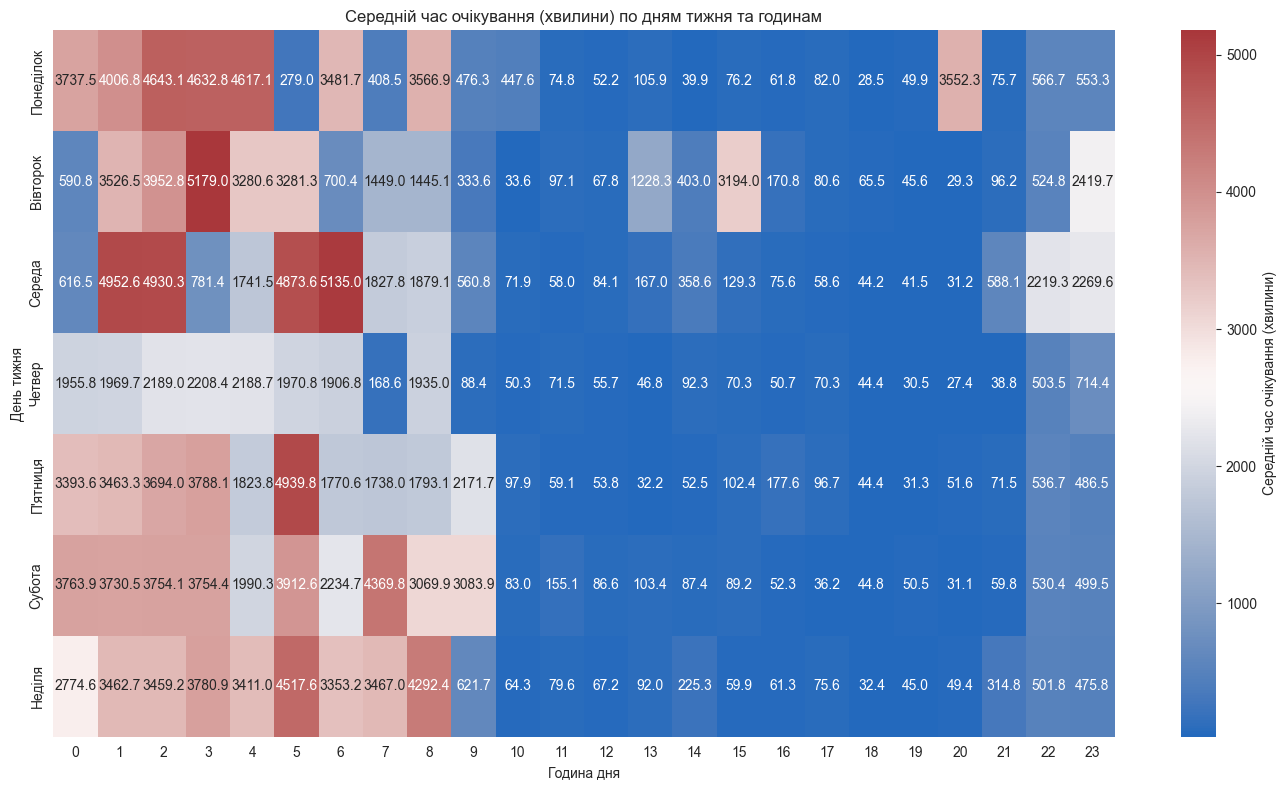

In [37]:
weekday_hourly_waiting = df.groupby(['request_weekday', 'request_hour'])['holding_time_min'].median().reset_index()
waiting_pivot = weekday_hourly_waiting.pivot(index='request_weekday', columns='request_hour', values='holding_time_min')
waiting_pivot = waiting_pivot.reindex(columns=np.arange(24))

plt.figure(figsize=(14, 8))
sns.heatmap(waiting_pivot, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Середній час очікування (хвилини)'})
plt.title('Середній час очікування (хвилини) по дням тижня та годинам')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('heatmap_waiting_total.png')
plt.show()

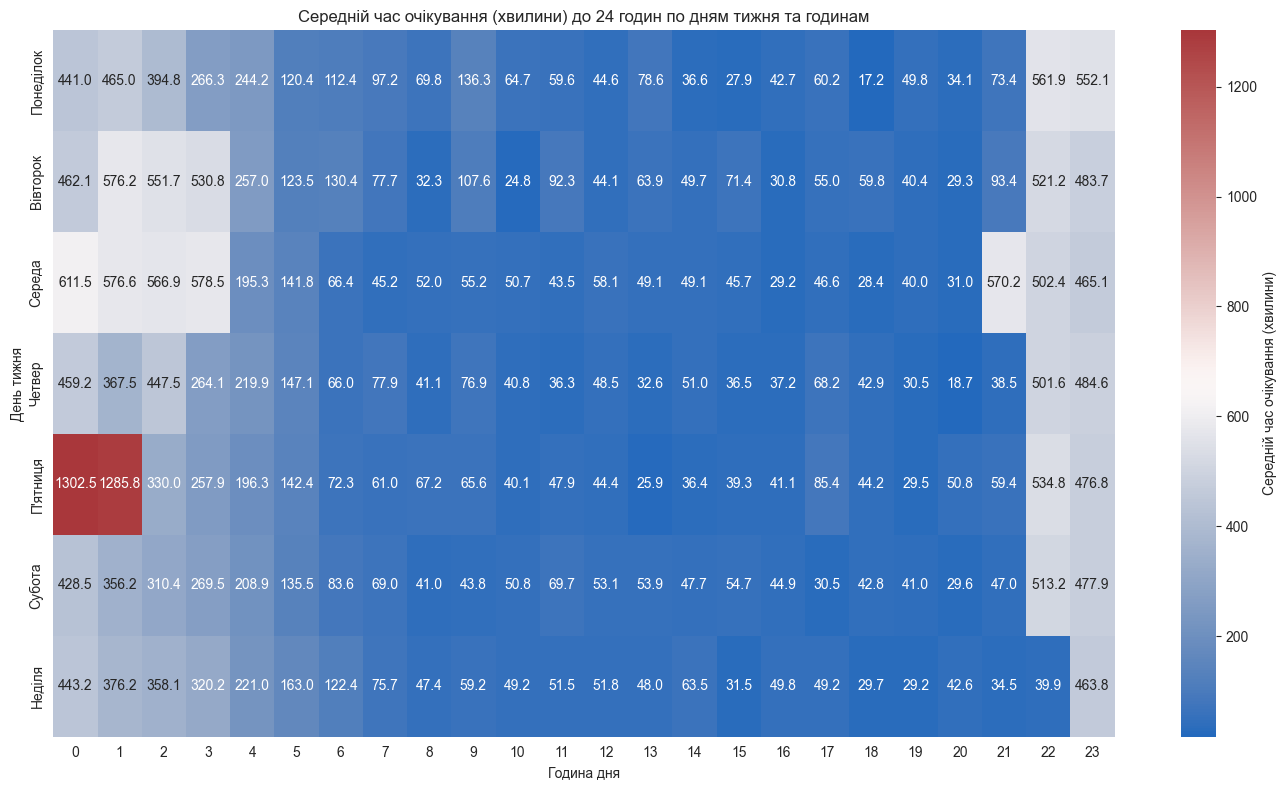

In [38]:
weekday_hourly_waiting = df_nrm.groupby(['request_weekday', 'request_hour'])['holding_time_min'].median().reset_index()
waiting_pivot = weekday_hourly_waiting.pivot(index='request_weekday', columns='request_hour', values='holding_time_min')
waiting_pivot = waiting_pivot.reindex(columns=np.arange(24))

plt.figure(figsize=(14, 8))
sns.heatmap(waiting_pivot, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Середній час очікування (хвилини)'})
plt.title('Середній час очікування (хвилини) до 24 годин по дням тижня та годинам')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('heatmap_waiting_nrm_total.png')
plt.show()

#### Розгляд навантаження retail команди

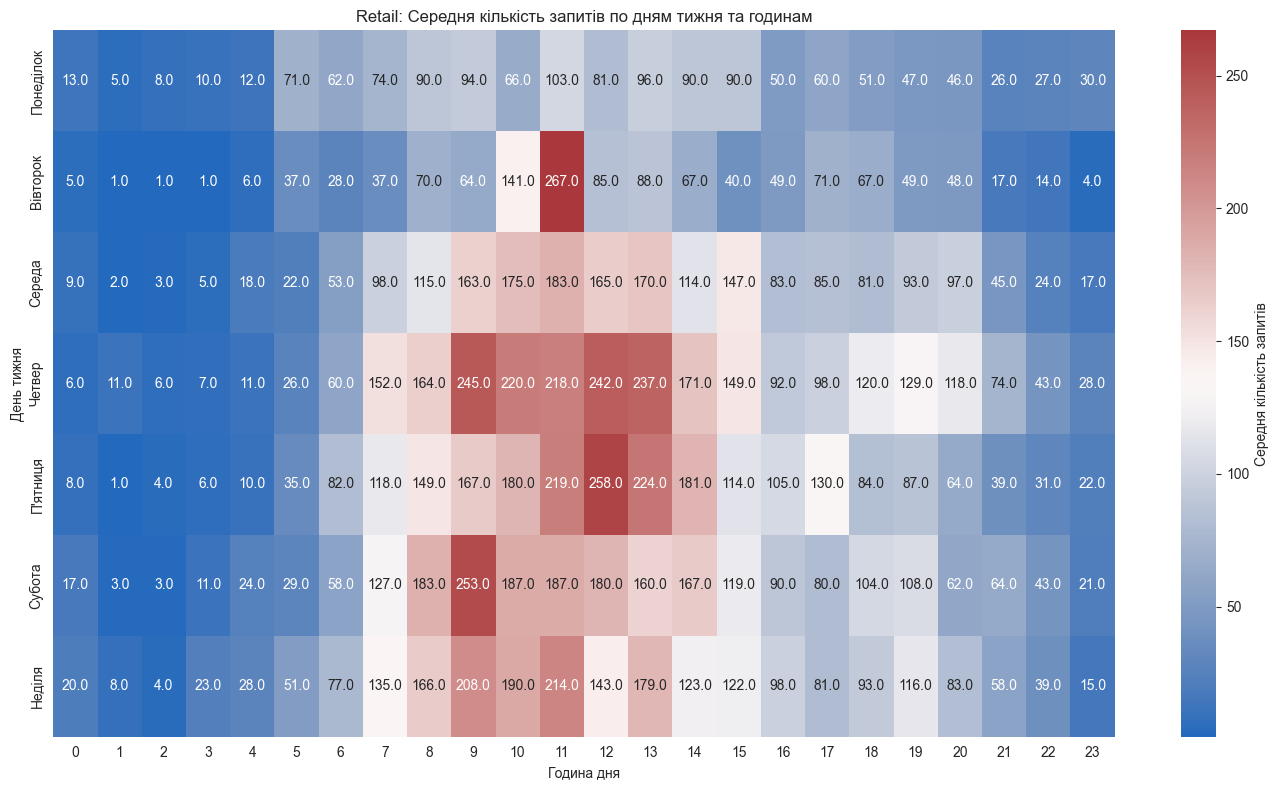

In [39]:
weekday_hourly_requests_retail = df_retail.groupby(['request_weekday', 'request_hour']).size().reset_index(name='request_count')
weekday_hourly_requests_retail_avg = weekday_hourly_requests_retail.groupby(
    ['request_weekday', 'request_hour']).agg(
        avg_requests=('request_count', 'mean'), 
        variance_requests=('request_count', 'var')
).reset_index()

requests_retail_avg_pivot = weekday_hourly_requests_retail_avg.pivot(index='request_weekday', columns='request_hour', values='avg_requests')

plt.figure(figsize=(14, 8))
sns.heatmap(requests_retail_avg_pivot, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Середня кількість запитів'})
plt.title('Retail: Середня кількість запитів по дням тижня та годинам')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('heatmap_requests_retail.png')
plt.show()

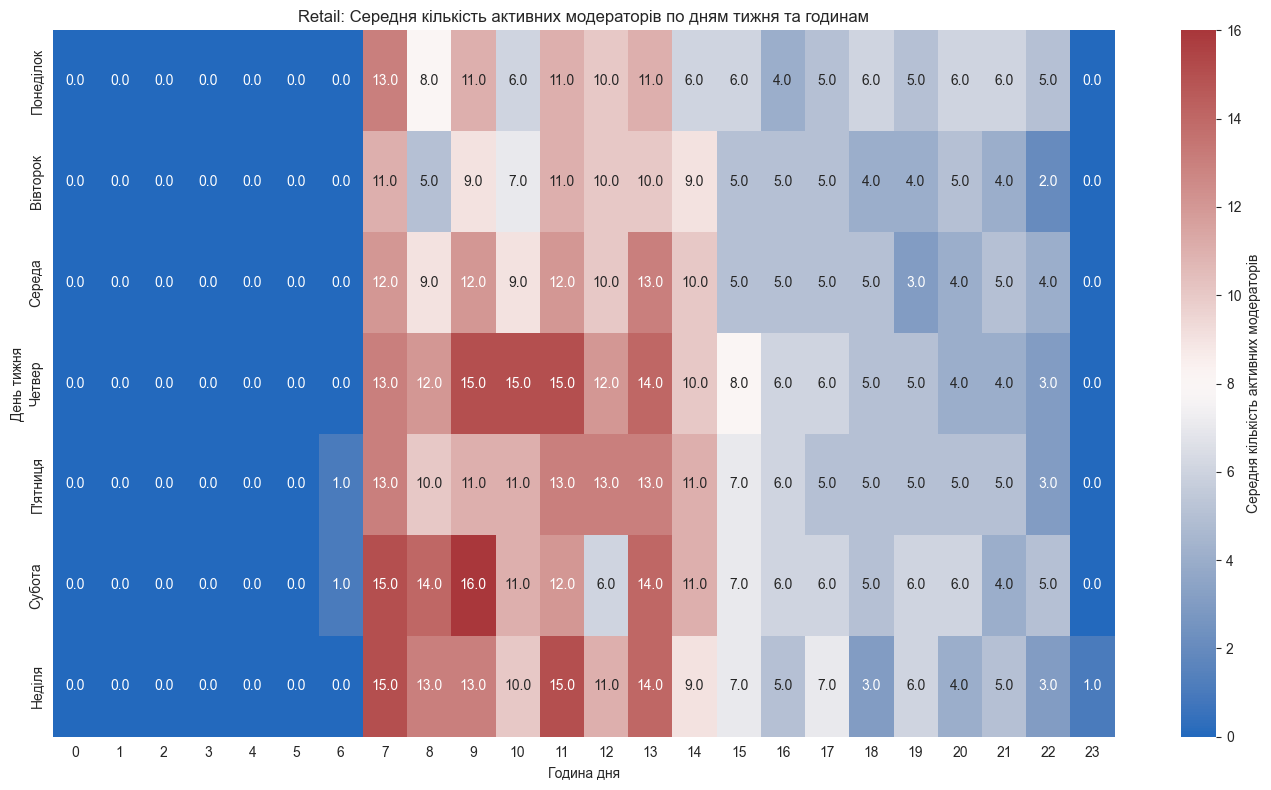

In [40]:
weekday_hourly_moderators_retail = df_retail.groupby(['start_weekday', 'start_hour'])['moderator'].nunique().reset_index(name='moderator_count')
weekday_hourly_moderators_retail_avg = weekday_hourly_moderators_retail.groupby(
    ['start_weekday', 'start_hour']).agg(
        avg_moderators=('moderator_count', 'mean'),
        variance_moderators=('moderator_count', 'var')
).reset_index()

moderators_retail_pivot = weekday_hourly_moderators_retail_avg.pivot(index='start_weekday', columns='start_hour', values='avg_moderators').fillna(0)
moderators_retail_pivot = moderators_retail_pivot.reindex(columns=np.arange(24), fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(moderators_retail_pivot, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Середня кількість активних модераторів'})
plt.title('Retail: Середня кількість активних модераторів по дням тижня та годинам')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('heatmap_moderators_retail.png')
plt.show()

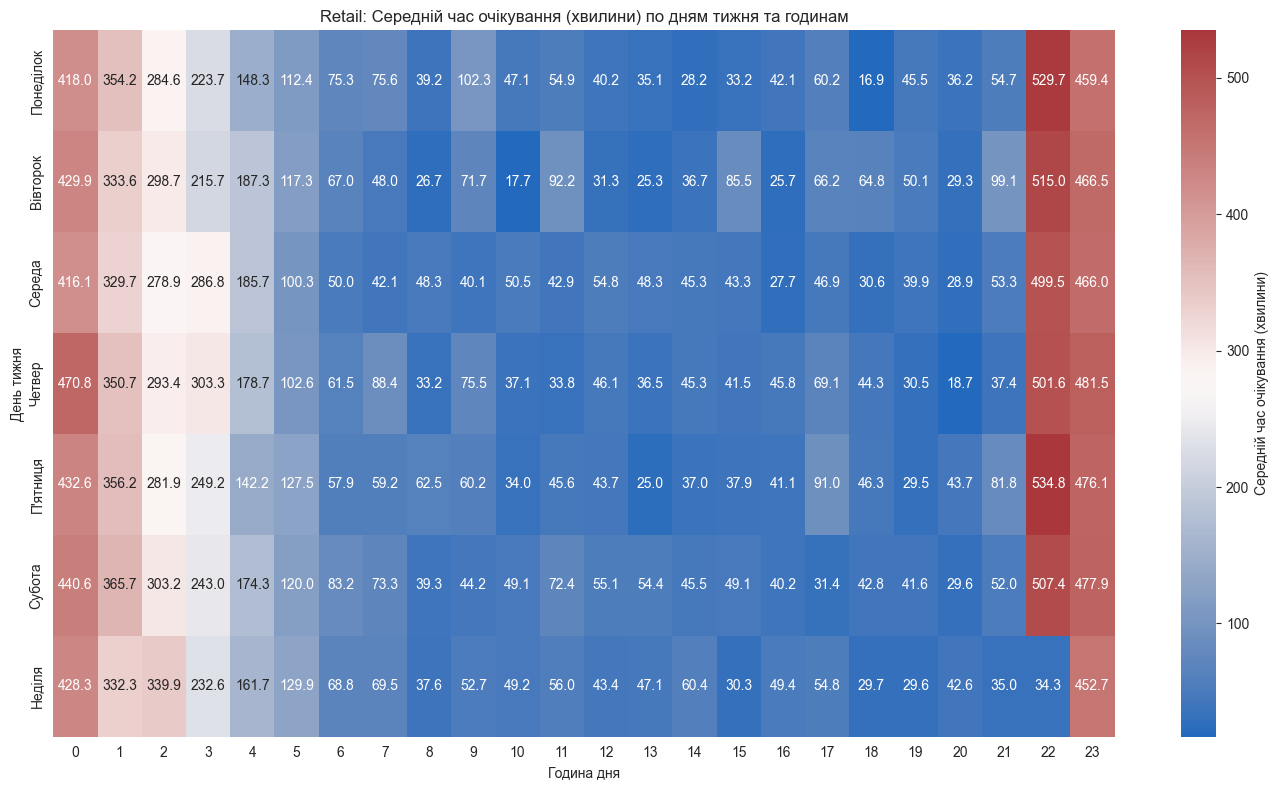

In [41]:
weekday_hourly_waiting = df_retail.groupby(['request_weekday', 'request_hour'])['holding_time_min'].median().reset_index()

waiting_pivot = weekday_hourly_waiting.pivot(index='request_weekday', columns='request_hour', values='holding_time_min')
waiting_pivot = waiting_pivot.reindex(columns=np.arange(24))

plt.figure(figsize=(14, 8))
sns.heatmap(waiting_pivot, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Середній час очікування (хвилини)'})
plt.title('Retail: Середній час очікування (хвилини) по дням тижня та годинам')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('heatmap_waiting_retail.png')
plt.show()

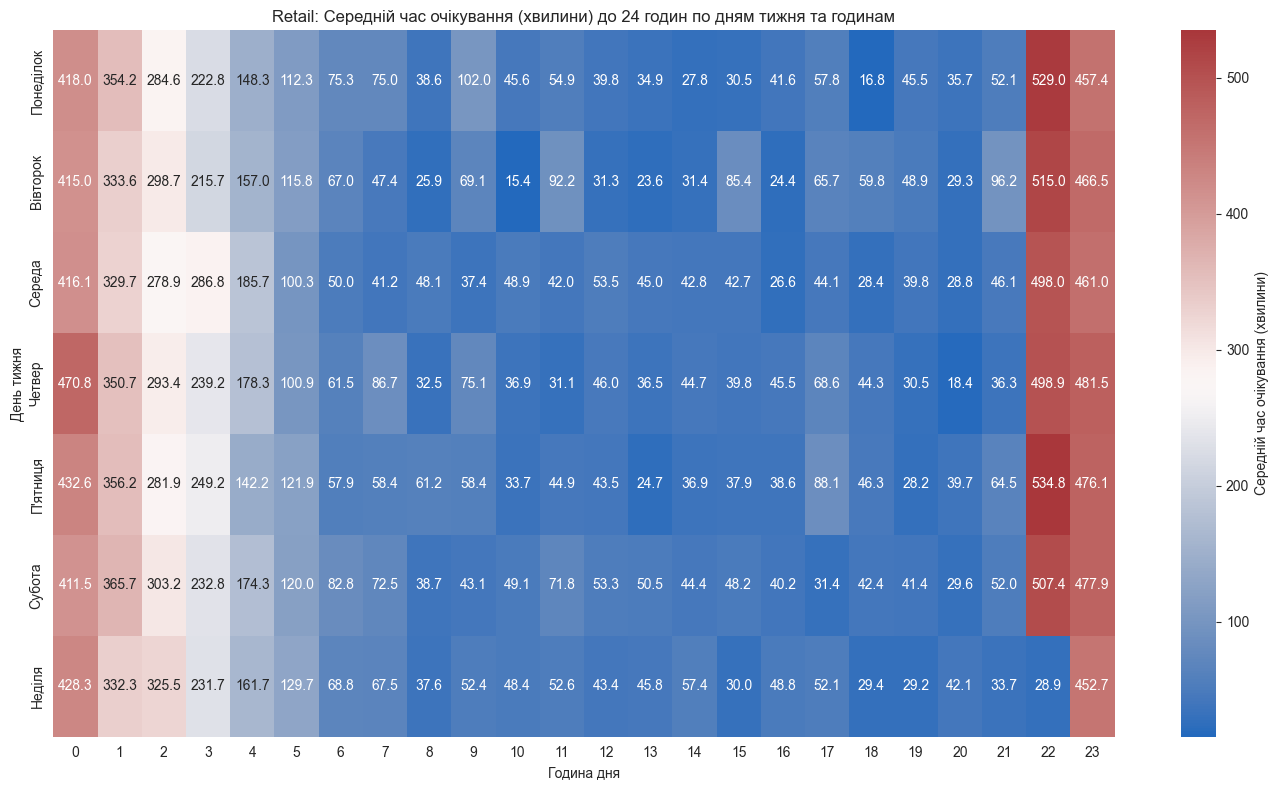

In [42]:
weekday_hourly_waiting = df_retail_nrm.groupby(['request_weekday', 'request_hour'])['holding_time_min'].median().reset_index()

waiting_pivot = weekday_hourly_waiting.pivot(index='request_weekday', columns='request_hour', values='holding_time_min')
waiting_pivot = waiting_pivot.reindex(columns=np.arange(24))

plt.figure(figsize=(14, 8))
sns.heatmap(waiting_pivot, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Середній час очікування (хвилини)'})
plt.title('Retail: Середній час очікування (хвилини) до 24 годин по дням тижня та годинам')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('heatmap_waiting_nrm_retail.png')
plt.show()

#### Розгляд навантаження wholesale команди

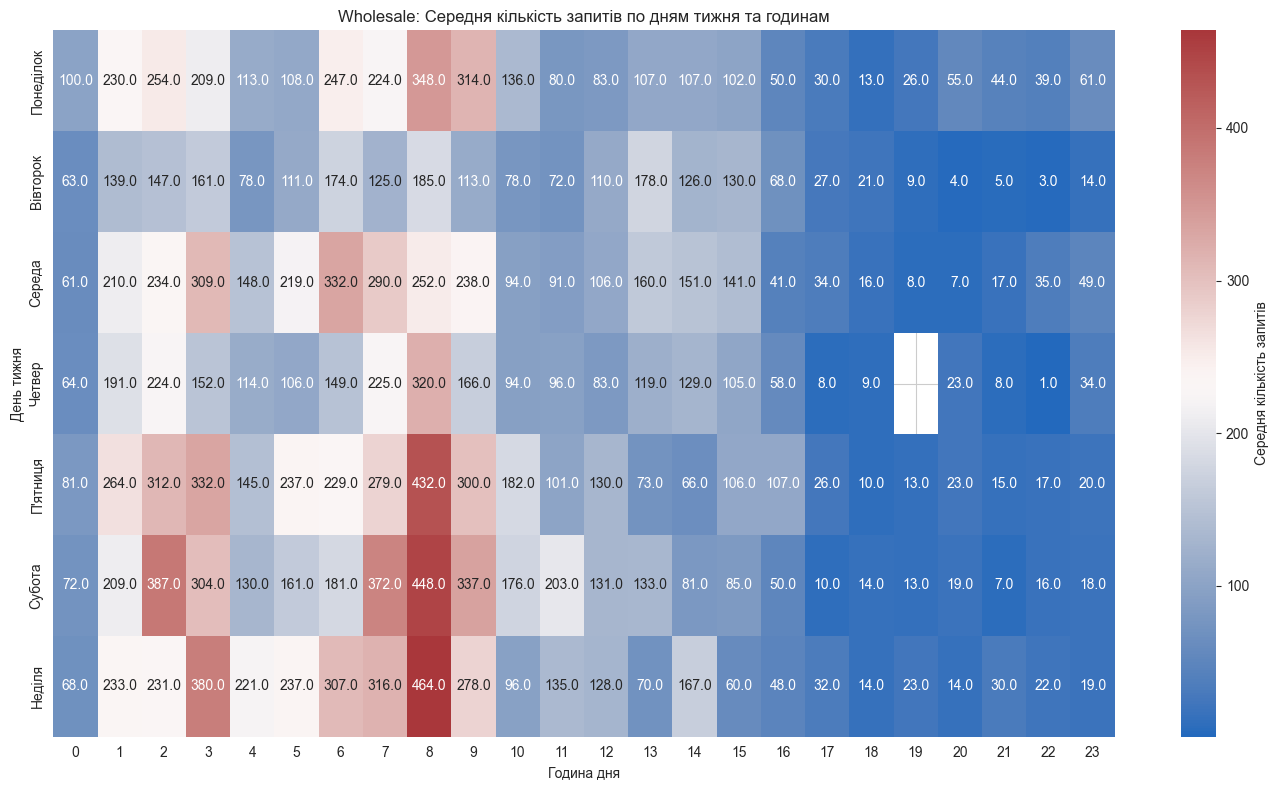

In [43]:
weekday_hourly_requests_wholesale = df_wholesale.groupby(['request_weekday', 'request_hour']).size().reset_index(name='request_count')
weekday_hourly_requests_wholesale_avg = weekday_hourly_requests_wholesale.groupby(
    ['request_weekday', 'request_hour']).agg(
        avg_requests=('request_count', 'mean'), 
        variance_requests=('request_count', 'var')
).reset_index()

requests_wholesale_avg_pivot = weekday_hourly_requests_wholesale_avg.pivot(index='request_weekday', columns='request_hour', values='avg_requests')

plt.figure(figsize=(14, 8))
sns.heatmap(requests_wholesale_avg_pivot, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Середня кількість запитів'})
plt.title('Wholesale: Середня кількість запитів по дням тижня та годинам')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('heatmap_requests_wholesale.png')
plt.show()

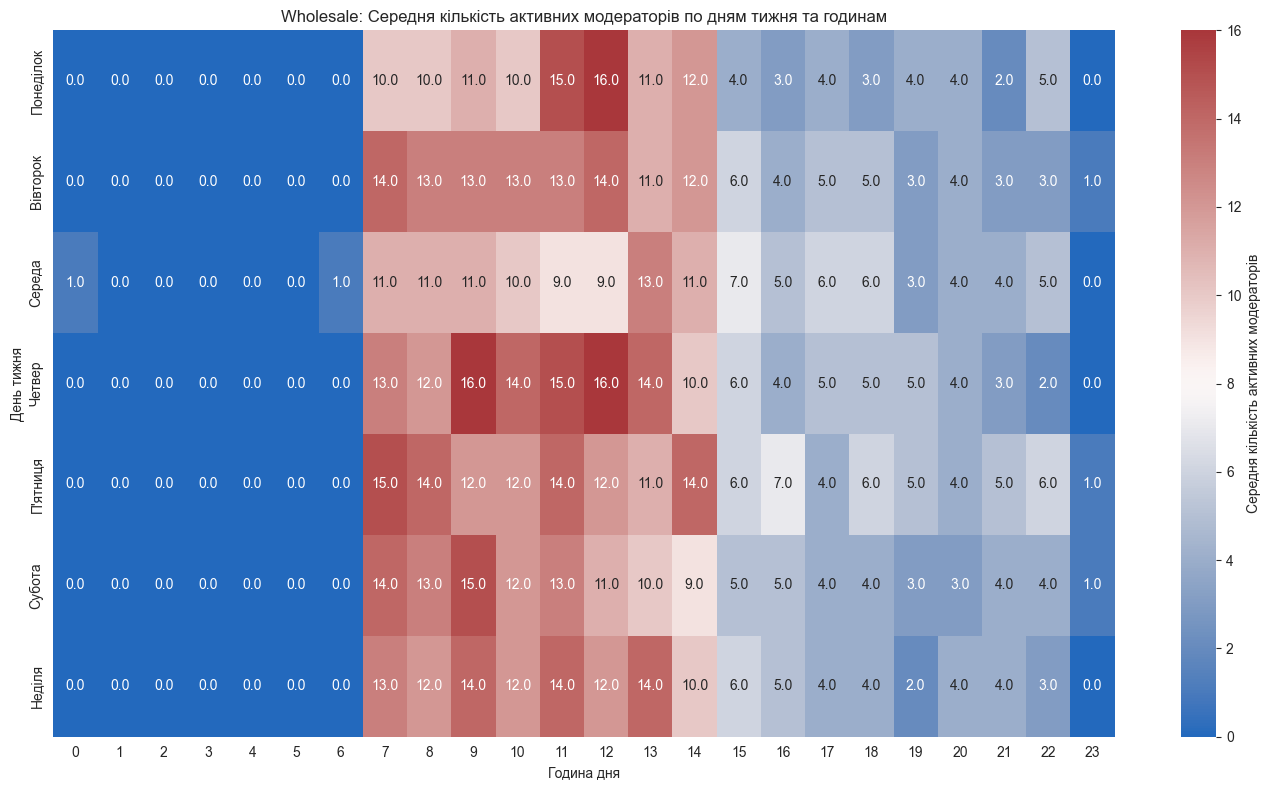

In [44]:
weekday_hourly_moderators_wholesale = df_wholesale.groupby(['start_weekday', 'start_hour'])['moderator'].nunique().reset_index(name='moderator_count')
weekday_hourly_moderators_wholesale_avg = weekday_hourly_moderators_wholesale.groupby(
    ['start_weekday', 'start_hour']).agg(
        avg_moderators=('moderator_count', 'mean'),
        variance_moderators=('moderator_count', 'var')
).reset_index()

moderators_wholesale_pivot = weekday_hourly_moderators_wholesale_avg.pivot(index='start_weekday', columns='start_hour', values='avg_moderators').fillna(0)
moderators_wholesale_pivot = moderators_wholesale_pivot.reindex(columns=np.arange(24), fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(moderators_wholesale_pivot, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Середня кількість активних модераторів'})
plt.title('Wholesale: Середня кількість активних модераторів по дням тижня та годинам')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('heatmap_moderators_wholesale.png')
plt.show()

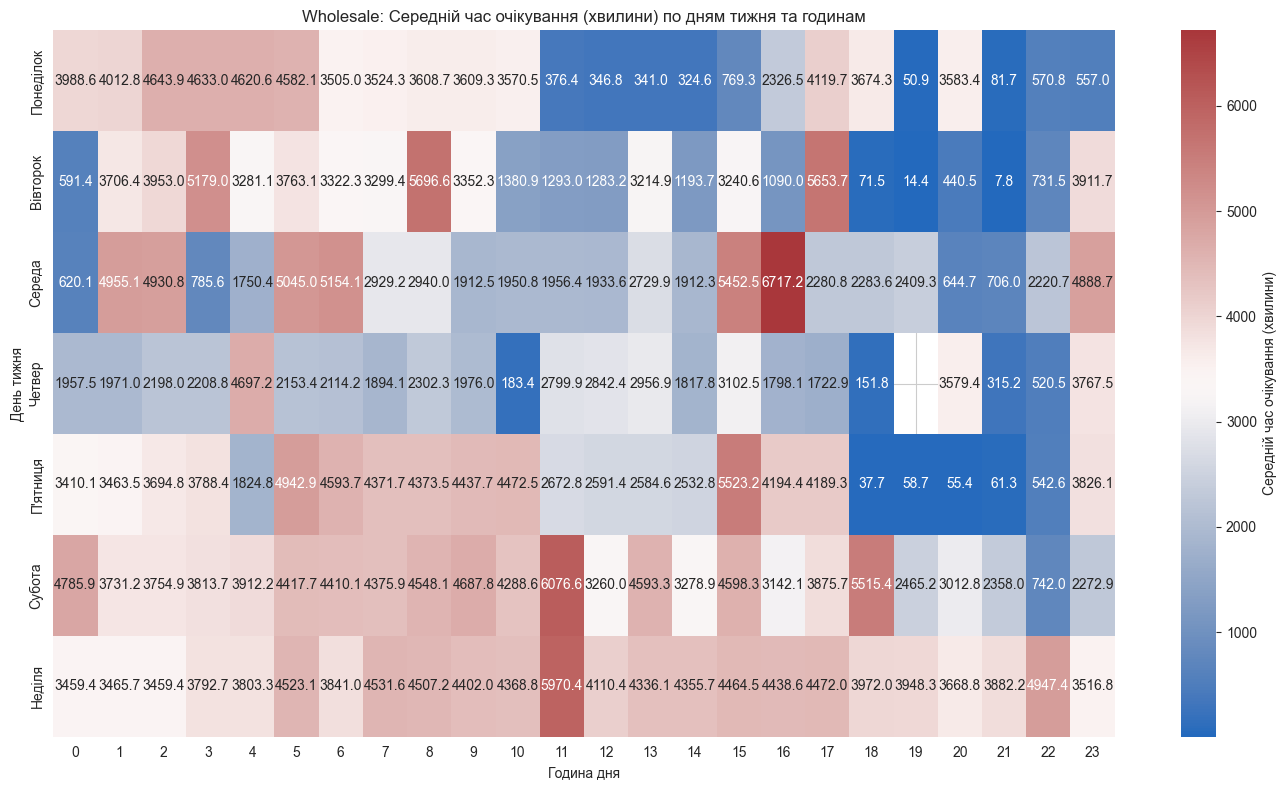

In [45]:
weekday_hourly_waiting = df_wholesale.groupby(['request_weekday', 'request_hour'])['holding_time_min'].median().reset_index()

waiting_pivot = weekday_hourly_waiting.pivot(index='request_weekday', columns='request_hour', values='holding_time_min')
waiting_pivot = waiting_pivot.reindex(columns=np.arange(24))

plt.figure(figsize=(14, 8))
sns.heatmap(waiting_pivot, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Середній час очікування (хвилини)'})
plt.title('Wholesale: Середній час очікування (хвилини) по дням тижня та годинам')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('heatmap_waiting_wholesale.png')
plt.show()

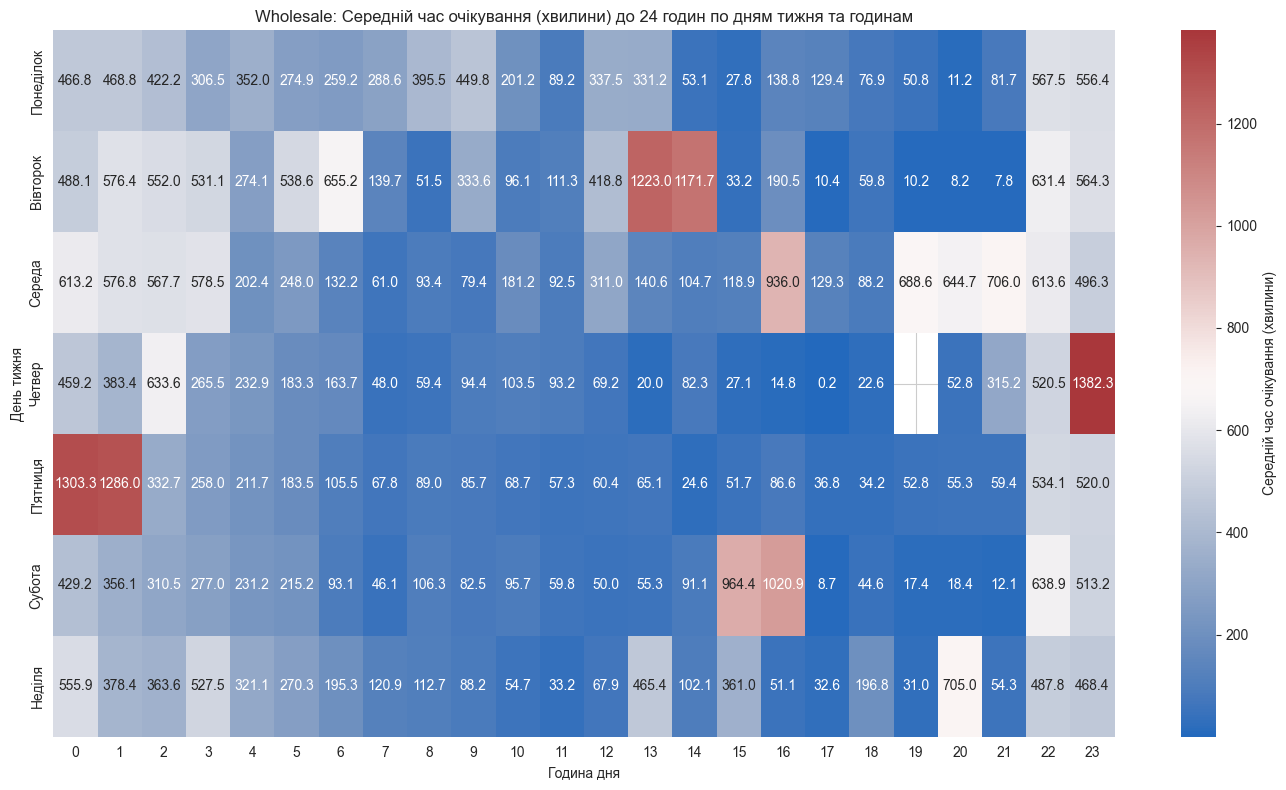

In [46]:
weekday_hourly_waiting = df_wholesale_nrm.groupby(['request_weekday', 'request_hour'])['holding_time_min'].median().reset_index()
waiting_pivot = weekday_hourly_waiting.pivot(index='request_weekday', columns='request_hour', values='holding_time_min')
waiting_pivot = waiting_pivot.reindex(columns=np.arange(24))

plt.figure(figsize=(14, 8))
sns.heatmap(waiting_pivot, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Середній час очікування (хвилини)'})
plt.title('Wholesale: Середній час очікування (хвилини) до 24 годин по дням тижня та годинам')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('heatmap_waiting_nrm_wholesale.png')
plt.show()

## Оцінка можливості об'єднання команд

Якщо команди мають однаковий паттерн навантаження, об'єднання не має сенсу, адже це не мало б значних переваг, але ускладнило б процес навчання та розширило б необхідну спеціалізацію. Якщо пікові кількості запитів надходять в різний час, об'єднання команд дозволило б уникнути скачків у зайнятості працівників, а тому й зменшило б час очікування через нестачу співробітників. 

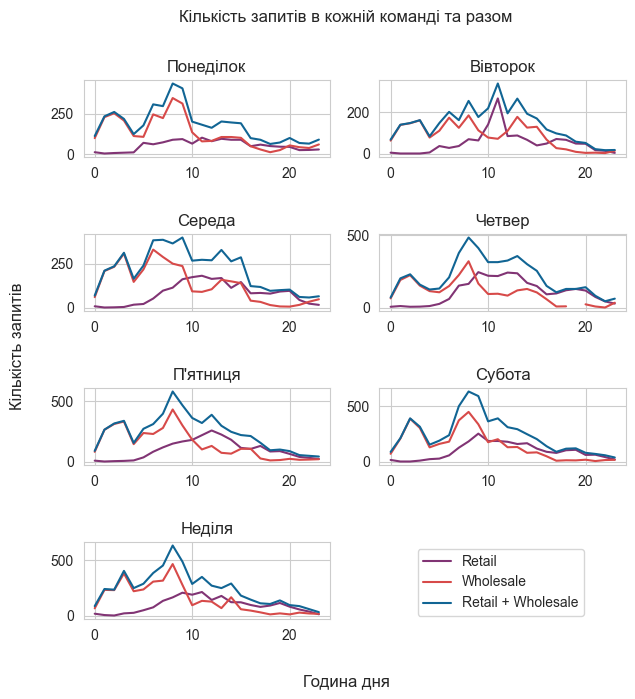

In [47]:
fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(421)
ax1.plot(requests_retail_avg_pivot[requests_retail_avg_pivot.index==0].transpose(), color = '#813474')
ax1.plot(requests_wholesale_avg_pivot[requests_wholesale_avg_pivot.index==0].transpose(), color = '#d74a49')
ax1.plot(requests_avg_pivot[requests_avg_pivot.index==0].transpose(), color = '#116594')
ax1.set_title('Понеділок')

ax2 = fig.add_subplot(422)
ax2.plot(requests_retail_avg_pivot[requests_retail_avg_pivot.index==1].transpose(), color = '#813474')
ax2.plot(requests_wholesale_avg_pivot[requests_wholesale_avg_pivot.index==1].transpose(), color = '#d74a49')
ax2.plot(requests_avg_pivot[requests_avg_pivot.index==1].transpose(), color = '#116594')
ax2.set_title('Вівторок')

ax3 = fig.add_subplot(423)
ax3.plot(requests_retail_avg_pivot[requests_retail_avg_pivot.index==2].transpose(), color = '#813474')
ax3.plot(requests_wholesale_avg_pivot[requests_wholesale_avg_pivot.index==2].transpose(), color = '#d74a49')
ax3.plot(requests_avg_pivot[requests_avg_pivot.index==2].transpose(), color = '#116594')
ax3.set_title('Середа')

ax4 = fig.add_subplot(424)
ax4.plot(requests_retail_avg_pivot[requests_retail_avg_pivot.index==3].transpose(), color = '#813474')
ax4.plot(requests_wholesale_avg_pivot[requests_wholesale_avg_pivot.index==3].transpose(), color = '#d74a49')
ax4.plot(requests_avg_pivot[requests_avg_pivot.index==3].transpose(), color = '#116594')
ax4.set_title('Четвер')

ax5 = fig.add_subplot(425)
ax5.plot(requests_retail_avg_pivot[requests_retail_avg_pivot.index==4].transpose(), color = '#813474')
ax5.plot(requests_wholesale_avg_pivot[requests_wholesale_avg_pivot.index==4].transpose(), color = '#d74a49')
ax5.plot(requests_avg_pivot[requests_avg_pivot.index==4].transpose(), color = '#116594')
ax5.set_title("П'ятниця")

ax6 = fig.add_subplot(426)
ax6.plot(requests_retail_avg_pivot[requests_retail_avg_pivot.index==5].transpose(), color = '#813474')
ax6.plot(requests_wholesale_avg_pivot[requests_wholesale_avg_pivot.index==5].transpose(), color = '#d74a49')
ax6.plot(requests_avg_pivot[requests_avg_pivot.index==5].transpose(), color = '#116594')
ax6.set_title('Субота')

ax7 = fig.add_subplot(427)
ax7.plot(requests_retail_avg_pivot[requests_retail_avg_pivot.index==6].transpose(), color = '#813474')
ax7.plot(requests_wholesale_avg_pivot[requests_wholesale_avg_pivot.index==6].transpose(), color = '#d74a49')
ax7.plot(requests_avg_pivot[requests_avg_pivot.index==6].transpose(), color = '#116594')
ax7.set_title('Неділя')


fig.suptitle('Кількість запитів в кожній команді та разом')
fig.supxlabel('Година дня')
fig.supylabel('Кількість запитів')
fig.legend(['Retail', 'Wholesale', 'Retail + Wholesale'], bbox_to_anchor=(0.35, -0.28, 0.5, 0.5))
plt.subplots_adjust(hspace=1)

plt.savefig('union_requests.png')

## Оцінка можливості зміну графіку та навантаження

Для того, аби на кожну годину кожного дня тижня призначити необхідну кількість людей, треба виявити, який рівень виконання замовлень за годину є прийнятним.

Середній час виконання завдання має дорівнювати 5-ти хвилинам. Половину цього часу, 2.5 хвилин, можна додати на відпочинок та людський фактор.

In [48]:
60/7.5

8.0

Також можна оцінити наявний рівень опрацювань за годину.

In [49]:
requests_per_hour = df.groupby(['start_weekday', 'start_hour', 'team']).size().reset_index(name='request_count')
moderators_per_hour = df.groupby(['start_weekday', 'start_hour', 'team'])['moderator'].nunique().reset_index(name='moderator_count')
workload_df = pd.merge(requests_per_hour, moderators_per_hour, on=['start_weekday', 'start_hour', 'team'])
workload_df['requests_per_moderator'] = workload_df['request_count'] / workload_df['moderator_count']
median_waiting_time = df.groupby(['start_weekday', 'start_hour', 'team'])['holding_time_min'].median().reset_index(name='median_waiting_time_min')
workload_df = pd.merge(workload_df, median_waiting_time, on=['start_weekday', 'start_hour', 'team'])

average_requests_per_moderator = workload_df.groupby('team')['requests_per_moderator'].mean().reset_index()
print(average_requests_per_moderator)

        team  requests_per_moderator
0     retail               14.982533
1  wholesale               24.817230


Wholesale команда має небажані показники часу очікування та має значний нестаток працівників, а тому не може використовуватися як орієнтир. Retail команда має середні показники опрацювання **денних** запитів у 30-45 хвилин. Враховуючи те, що вдвічі менший час (15 хвилин) є бажаним для менеджменту, має сенс удвічі скоротити очікуваний рівень опрацювань. 

In [50]:
14.98/2

7.49

Цей показник відповідає нашій попередній оцінці. Також найнижчий рівень середнього очікування існує в retail команді у понеділок, 18.00-18.59, це 17 хвилин очікування. Тоді в середньому відбувається 51 запит, та присутньо 6 працівників.

In [51]:
51/6

8.5

Отже, показник у 8 опрацьованих запитів на годину на одного модератора здається хорошим орієнтиром.

### Варіант 1: Встановлення цілодобового графіку роботи

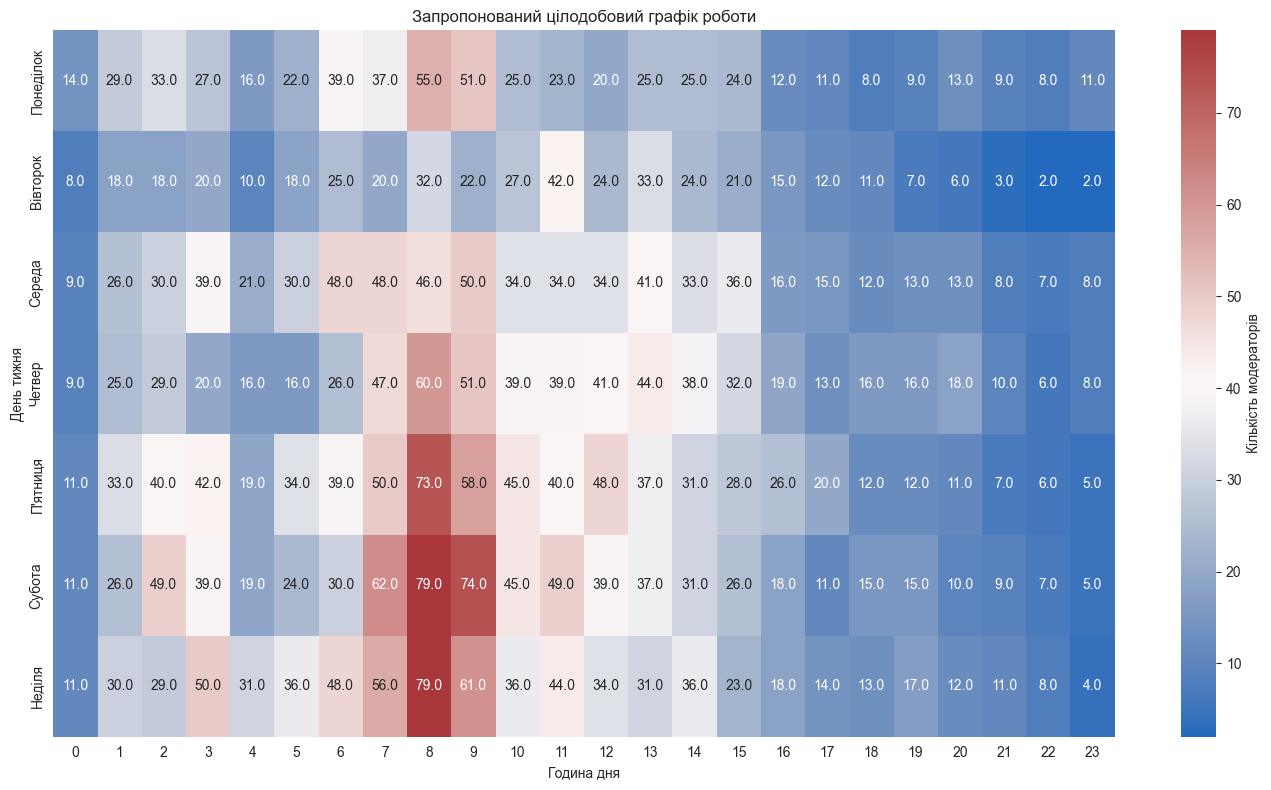

In [52]:
continuous_schedule = np.round(requests_avg_pivot / 8, 0)
plt.figure(figsize=(14, 8))
sns.heatmap(continuous_schedule, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Кількість модераторів'})
plt.title('Запропонований цілодобовий графік роботи')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('continuous_schedule.png')
plt.show()

In [53]:
continuous_schedule.to_numpy().sum()

np.float64(4444.0)

### Варіант 2: Перенесення записів про нічні запити на першу робочу годину

In [54]:
def to_morning(date):
    if date.hour < 7:
        new_date = dt.datetime(date.year, date.month, date.day, 7, 0, 0)
    elif date.hour > 21:
        next_date = date + dt.timedelta(hours=24)
        new_date = dt.datetime(next_date.year, next_date.month, next_date.day, 7, 0, 0)
    else:
        new_date = date
    return new_date

df_morning = df.copy(deep=True)
df_morning['request_time'] = df_morning['request_time'].apply(to_morning)
df_morning = df_morning[df_morning['request_time']<df_morning['start_time']]
df_morning['holding_time'] = df_morning['start_time']-df_morning['request_time']
df_morning['holding_time_min'] = df_morning['holding_time'].dt.total_seconds()/60
df_morning['request_weekday'] = df_morning['request_time'].dt.dayofweek
df_morning['request_date'] = df_morning['request_time'].dt.date
df_morning['request_hour'] = df_morning['request_time'].dt.hour

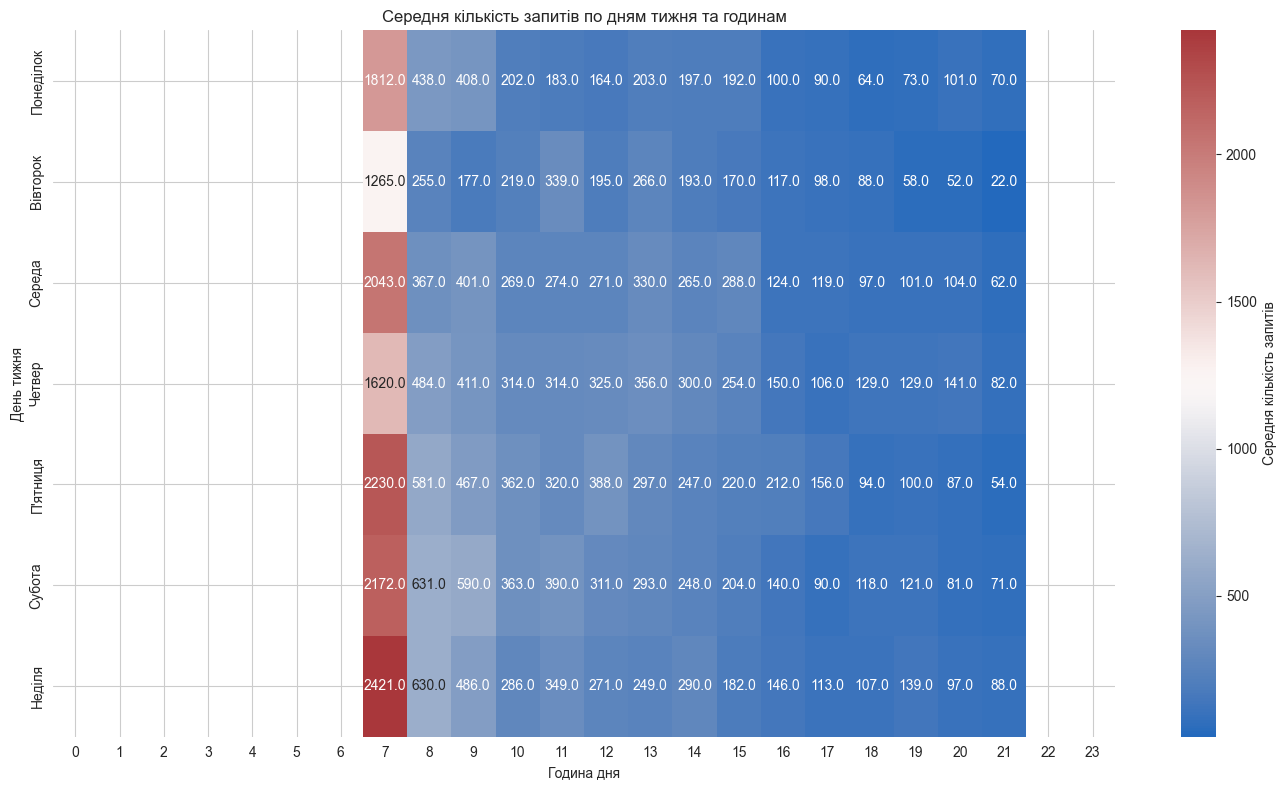

In [55]:
weekday_hourly_requests = df_morning.groupby(['request_weekday', 'request_hour']).size().reset_index(name='request_count')
weekday_hourly_requests_avg = weekday_hourly_requests.groupby(
    ['request_weekday', 'request_hour']).agg(
        avg_requests=('request_count', 'median'), 
        variance_requests=('request_count', 'var')
).reset_index()

requests_morning_avg_pivot = weekday_hourly_requests_avg.pivot(index='request_weekday', columns='request_hour', values='avg_requests')
requests_morning_avg_pivot = requests_morning_avg_pivot.reindex(columns=np.arange(24))

plt.figure(figsize=(14, 8))
sns.heatmap(requests_morning_avg_pivot, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Середня кількість запитів'})
plt.title('Середня кількість запитів по дням тижня та годинам')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('morning_requests_total.png')
plt.show()

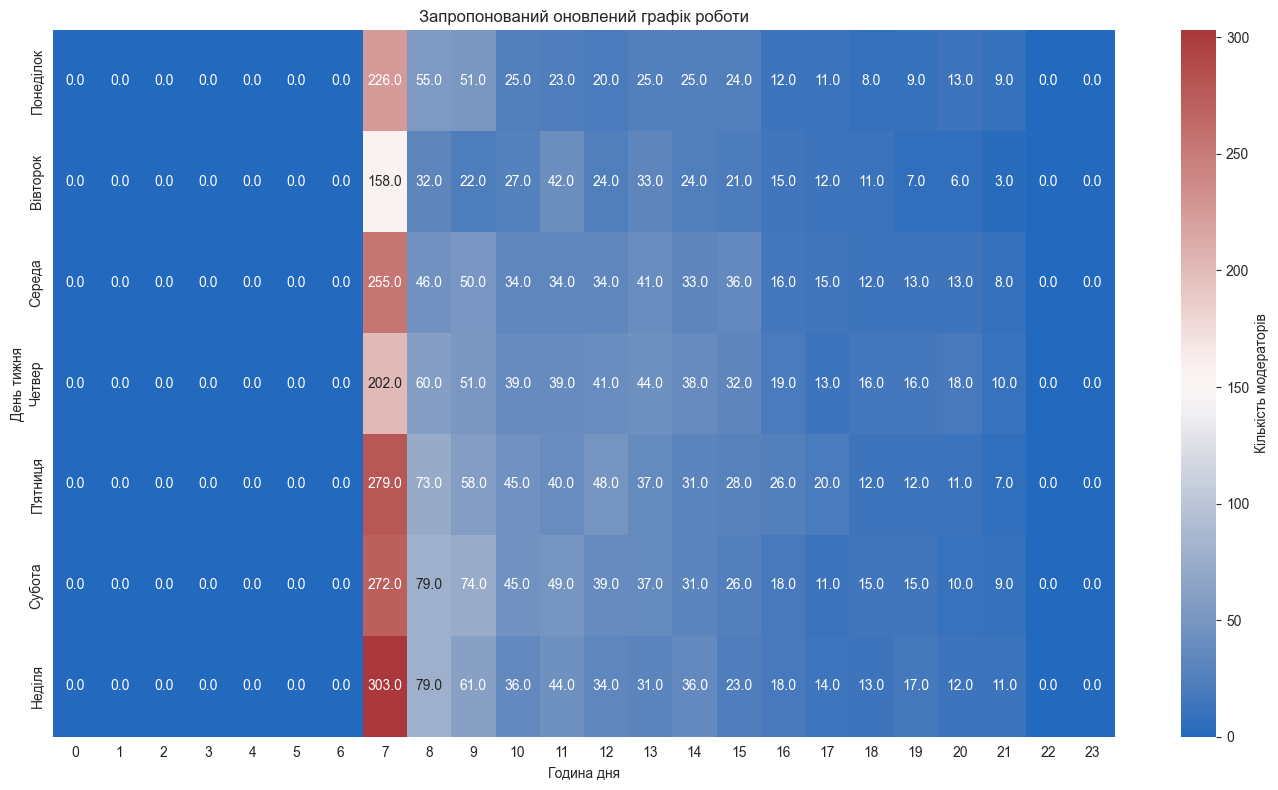

In [56]:
morning_schedule = np.round(requests_morning_avg_pivot.fillna(0) / 8, 0)

plt.figure(figsize=(14, 8))
sns.heatmap(morning_schedule, annot=True, fmt=".1f", cmap="vlag", cbar_kws={'label': 'Кількість модераторів'})
plt.title("Запропонований оновлений графік роботи")
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Понеділок', 'Вівторок', 'Середа', 'Четвер', "П'ятниця", 'Субота', 'Неділя'])
plt.xticks(ticks=np.arange(24) + 0.5, labels=range(24))
plt.tight_layout()
plt.savefig('morning_schedule.png')
plt.show()

In [57]:
morning_schedule.to_numpy().sum()

np.float64(4440.0)